In [2]:
# Load libraries

import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import Dense, Flatten, Conv1D, Embedding, MaxPool1D, Dropout, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

from music21 import *

In [3]:
# Function to read a MIDI file and convert it to an array of musical notes

def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [4]:
%cd /content/wavenet-music-gen/

/content/wavenet-music-gen


In [5]:
#specify the path
path='./input/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files], dtype=object)

Loading Music File: ./input/schumm-4.mid
Loading Music File: ./input/schubert_D850_2.mid
Loading Music File: ./input/schumm-6.mid
Loading Music File: ./input/schuim-2.mid
Loading Music File: ./input/schu_143_3.mid
Loading Music File: ./input/schub_d960_3.mid
Loading Music File: ./input/schuim-4.mid
Loading Music File: ./input/schubert_D850_1.mid
Loading Music File: ./input/schubert_D850_4.mid
Loading Music File: ./input/schumm-3.mid
Loading Music File: ./input/schubert_D935_4.mid
Loading Music File: ./input/schubert_D935_1.mid
Loading Music File: ./input/schub_d960_1.mid
Loading Music File: ./input/schumm-5.mid
Loading Music File: ./input/schumm-1.mid
Loading Music File: ./input/schub_d760_4.mid
Loading Music File: ./input/schub_d760_1.mid
Loading Music File: ./input/schubert_D850_3.mid
Loading Music File: ./input/schu_143_1.mid
Loading Music File: ./input/schuim-3.mid
Loading Music File: ./input/schumm-2.mid
Loading Music File: ./input/schuim-1.mid
Loading Music File: ./input/schub_d9

In [6]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

302


(array([187.,  38.,  27.,   9.,   8.,   9.,  11.,   5.,   4.,   4.]),
 array([1.0000e+00, 1.4080e+02, 2.8060e+02, 4.2040e+02, 5.6020e+02,
        7.0000e+02, 8.3980e+02, 9.7960e+02, 1.1194e+03, 1.2592e+03,
        1.3990e+03]),
 <a list of 10 Patch objects>)

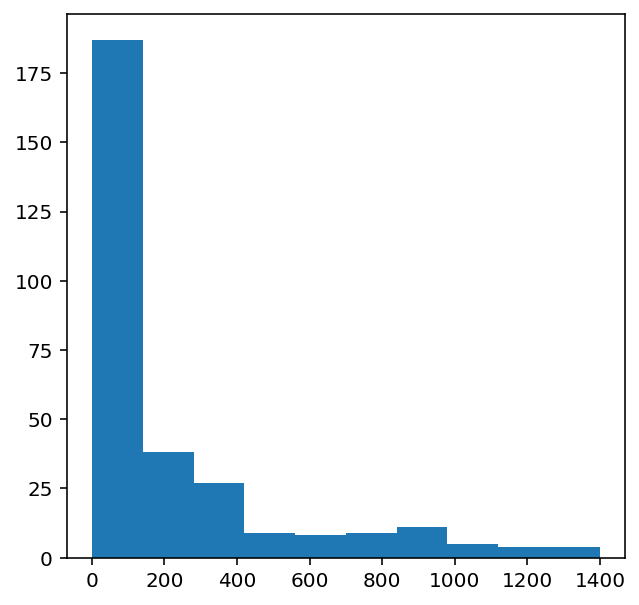

In [7]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [8]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

165


In [9]:
# discard less frequent notes (mostly will be noise or outliers)

new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music, dtype=object)

In [10]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [11]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [12]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [13]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [14]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [15]:
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           16500     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [17]:
filepath = "./working/saved_models-improvement-{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath,monitor = 'val_acc',verbose = 1,save_best_only = True,mode = 'max')
callbacks_list = [checkpoint]

In [18]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=1000, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=callbacks_list)

Epoch 1/1000
389/389 [==============================] - ETA: 0s - loss: 4.3311 - acc: 0.0543
Epoch 1: val_acc improved from -inf to 0.09458, saving model to ./working/saved_models-improvement-01-0.09.h5
389/389 [==============================] - 12s 8ms/step - loss: 4.3311 - acc: 0.0543 - val_loss: 3.9726 - val_acc: 0.0946
Epoch 2/1000
389/389 [==============================] - ETA: 0s - loss: 3.7550 - acc: 0.1117
Epoch 2: val_acc improved from 0.09458 to 0.12527, saving model to ./working/saved_models-improvement-02-0.13.h5
389/389 [==============================] - 2s 6ms/step - loss: 3.7550 - acc: 0.1117 - val_loss: 3.7900 - val_acc: 0.1253
Epoch 3/1000
387/389 [============================>.] - ETA: 0s - loss: 3.5791 - acc: 0.1336
Epoch 3: val_acc improved from 0.12527 to 0.14415, saving model to ./working/saved_models-improvement-03-0.14.h5
389/389 [==============================] - 2s 6ms/step - loss: 3.5791 - acc: 0.1336 - val_loss: 3.6946 - val_acc: 0.1442
Epoch 4/1000
383/389 

In [19]:
len(x_val)

12445

In [20]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

1/1 [==============================] - 0s 13ms/step
[44, 105, 44, 105, 44, 32, 105, 44, 161, 57]


In [21]:
random_music

array([151, 106, 151, 106, 151, 106,   7, 151, 106,  19, 116,  46,  46,
       116,  19, 106, 151, 140, 125, 105,  44, 105,  44, 105,  44, 105,
        44,  32, 105,  44, 161,  57])

In [22]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [23]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [24]:
convert_to_midi(predicted_notes)